## Семинар: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

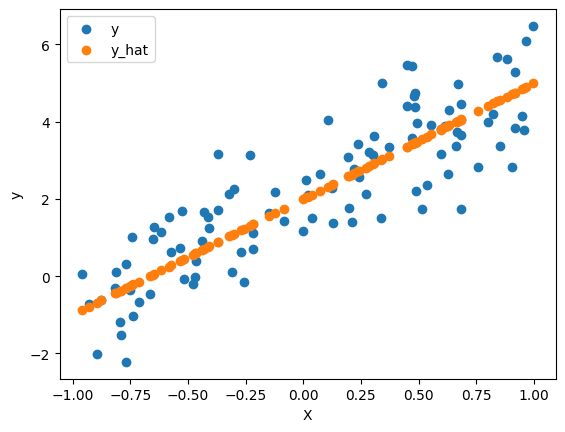

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

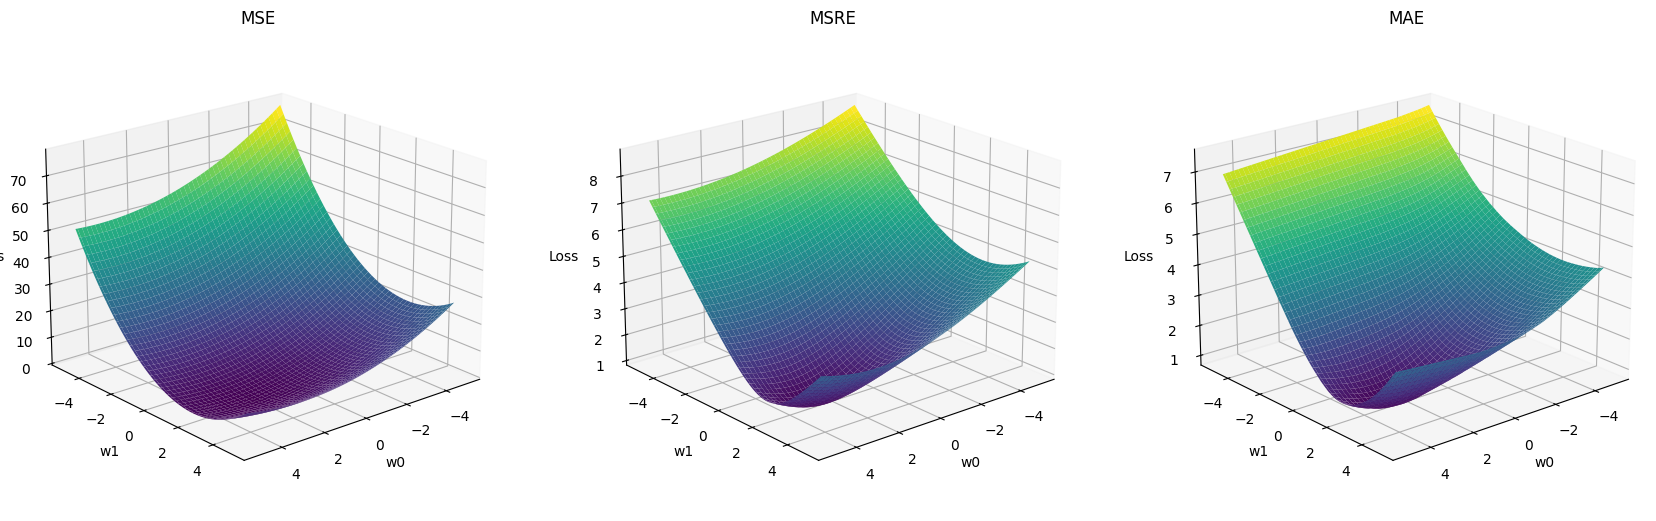

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [16]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [11]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [12]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [13]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [15]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: Requested MovieWriter (ffmpeg) not available

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [17]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [18]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.84MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 308kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 444kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.68MB/s]


In [19]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [20]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__()
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters

    def step(self):
        pass

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__()
        self.T_max = T_max
        self.eta_min = eta_min

    def step(self):
        pass

In [22]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True,  transform=transform, download=True)
test_ds  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 287kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.68MB/s]


In [23]:
# === Adam и AdamW ===
import torch

class Adam(Optimizer):
    def __init__(self, params, lr: float = 1e-3, betas=(0.9, 0.999), eps: float = 1e-8):
        super().__init__(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self._t = 0
        # состояние
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        self._t += 1
        b1, b2 = self.beta1, self.beta2
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                g = p.grad
                self.m[i] = b1 * self.m[i] + (1 - b1) * g
                self.v[i] = b2 * self.v[i] + (1 - b2) * (g * g)
                # bias-correction
                m_hat = self.m[i] / (1 - (b1 ** self._t))
                v_hat = self.v[i] / (1 - (b2 ** self._t))
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)


class AdamW(Optimizer):
    def __init__(self, params, lr: float = 1e-3, betas=(0.9, 0.999), eps: float = 1e-8, weight_decay: float = 0.01):
        super().__init__(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self._t = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        self._t += 1
        b1, b2 = self.beta1, self.beta2
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                # decoupled weight decay (как в AdamW)
                if self.weight_decay:
                    p -= self.lr * self.weight_decay * p

                g = p.grad
                self.m[i] = b1 * self.m[i] + (1 - b1) * g
                self.v[i] = b2 * self.v[i] + (1 - b2) * (g * g)
                m_hat = self.m[i] / (1 - (b1 ** self._t))
                v_hat = self.v[i] / (1 - (b2 ** self._t))
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)


In [24]:
# === LinearLR и CosineAnnealing ===
import math

class LinearLR(LRScheduler):
    """
    Линейная интерполяция множителя LR от start_factor к end_factor за total_iters шагов.
    Поддерживает как optimizer.lr, так и optimizer.eta (на случай разных оптимизаторов в ноутбуке).
    """
    def __init__(self,
                 optimizer: Optimizer,
                 start_factor: float = 0.1,
                 end_factor: float = 1.0,
                 total_iters: int = 100):
        super().__init__(optimizer)
        self.start_factor = float(start_factor)
        self.end_factor = float(end_factor)
        self.total_iters = max(1, int(total_iters))
        self.last_iter = 0

        self._has_lr = hasattr(self.optimizer, "lr")
        self._has_eta = hasattr(self.optimizer, "eta")
        if not (self._has_lr or self._has_eta):
            raise AttributeError("Optimizer must have either 'lr' or 'eta' attribute.")
        self._base = getattr(self.optimizer, "lr", None) if self._has_lr else getattr(self.optimizer, "eta", None)

    def _factor(self, t: int) -> float:
        if t >= self.total_iters:
            return self.end_factor
        alpha = t / float(self.total_iters)
        return self.start_factor + (self.end_factor - self.start_factor) * alpha

    def step(self):
        self.last_iter += 1
        factor = self._factor(self.last_iter)
        if self._has_lr:
            self.optimizer.lr = self._base * factor
        if self._has_eta:
            self.optimizer.eta = self._base * factor


class CosineAnnealing(LRScheduler):
    """
    Косинусное затухание множителя LR от 1.0 к eta_min за T_max шагов:
        factor(t) = eta_min + 0.5 * (1 - eta_min) * (1 + cos(pi * t / T_max))
    eta_min можно передать как долю от базового LR (0..1) или абсолютным значением,
    тогда он будет автоматически преобразован в долю.
    """
    def __init__(self,
                 optimizer: Optimizer,
                 T_max: int = 20,
                 eta_min: float = 0.0):
        super().__init__(optimizer)
        self.T_max = max(1, int(T_max))
        self.eta_min_factor = float(eta_min)
        self.last_iter = 0

        self._has_lr = hasattr(self.optimizer, "lr")
        self._has_eta = hasattr(self.optimizer, "eta")
        if not (self._has_lr or self._has_eta):
            raise AttributeError("Optimizer must have either 'lr' or 'eta' attribute.")
        self._base = getattr(self.optimizer, "lr", None) if self._has_lr else getattr(self.optimizer, "eta", None)

        # если eta_min был передан абсолютным LR — переведём в фактор
        if self.eta_min_factor > 0 and self.eta_min_factor > self._base:
            self.eta_min_factor = self.eta_min_factor / self._base

    def _factor(self, t: int) -> float:
        if t >= self.T_max:
            return self.eta_min_factor
        return self.eta_min_factor + 0.5 * (1 - self.eta_min_factor) * (1 + math.cos(math.pi * t / float(self.T_max)))

    def step(self):
        self.last_iter += 1
        factor = self._factor(self.last_iter)
        if self._has_lr:
            self.optimizer.lr = self._base * factor
        if self._has_eta:
            self.optimizer.eta = self._base * factor


In [25]:
# === Демо-обучение CNN и сравнение оптимизаторов/шедулеров ===
import torch
from torch import nn
from torch.utils.data import DataLoader
try:
    from torchvision import datasets, transforms
    HAS_TORCHVISION = True
except Exception:
    HAS_TORCHVISION = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Датасет: MNIST (если есть torchvision/интернет) или синтетический fallback.
if HAS_TORCHVISION:
    transform = transforms.Compose([transforms.ToTensor()])
    try:
        train_ds = datasets.MNIST(root="./data", train=True,  transform=transform, download=True)
        test_ds  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    except Exception:
        HAS_TORCHVISION = False

if not HAS_TORCHVISION:
    # оффлайн вариант — синтетика 1x28x28, 10 классов
    N_train, N_test = 2000, 500
    Xtr = torch.randn(N_train, 1, 28, 28); ytr = torch.randint(0, 10, (N_train,))
    Xte = torch.randn(N_test,  1, 28, 28); yte = torch.randint(0, 10, (N_test,))
    from torch.utils.data import TensorDataset
    train_ds = TensorDataset(Xtr, ytr)
    test_ds  = TensorDataset(Xte, yte)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=128)

# Простая CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*7*7, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x): return self.net(x)

def train_eval(make_opt, make_sched=None, epochs=3):
    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = make_opt(model.parameters())
    sched = make_sched(opt) if make_sched else None

    def run_epoch(dl, train=True):
        model.train(train)
        total, correct, loss_sum = 0, 0, 0.0
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            if train:
                opt.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                opt.step()
                if sched: sched.step()
            else:
                with torch.no_grad():
                    out = model(xb)
                    loss = criterion(out, yb)
            loss_sum += loss.item() * xb.size(0)
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += xb.size(0)
        return loss_sum/total, correct/total

    history = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
    for ep in range(epochs):
        tl, ta = run_epoch(train_dl, True)
        vl, va = run_epoch(test_dl, False)
        history["train_loss"].append(tl); history["train_acc"].append(ta)
        history["test_loss"].append(vl); history["test_acc"].append(va)
        print(f"epoch {ep+1}: train_loss={tl:.4f} acc={ta:.3f} | test_loss={vl:.4f} acc={va:.3f}")
    return history

# Сравнение оптимизаторов
hist_sgd   = train_eval(lambda p: SGD(p, lr=0.05), epochs=3)
hist_adam  = train_eval(lambda p: Adam(p, lr=1e-3),  epochs=3)
hist_adamw = train_eval(lambda p: AdamW(p, lr=1e-3, weight_decay=0.01), epochs=3)

# Примеры со шедулерами:
# линейный разогрев для SGD
hist_sgd_lin = train_eval(
    lambda p: SGD(p, lr=0.05),
    lambda opt: LinearLR(opt, start_factor=0.2, end_factor=1.0, total_iters=len(train_dl)*2),
    epochs=3
)

# косинусное затухание для Adam
hist_adam_cos = train_eval(
    lambda p: Adam(p, lr=1e-3),
    lambda opt: CosineAnnealing(opt, T_max=len(train_dl)*2, eta_min=0.1),
    epochs=3
)


epoch 1: train_loss=0.5311 acc=0.831 | test_loss=0.1169 acc=0.964
epoch 2: train_loss=0.1067 acc=0.968 | test_loss=0.1134 acc=0.963
epoch 3: train_loss=0.0734 acc=0.978 | test_loss=0.0771 acc=0.975
epoch 1: train_loss=0.2508 acc=0.926 | test_loss=0.0733 acc=0.977
epoch 2: train_loss=0.0638 acc=0.981 | test_loss=0.0481 acc=0.983
epoch 3: train_loss=0.0468 acc=0.986 | test_loss=0.0436 acc=0.987
epoch 1: train_loss=0.2660 acc=0.918 | test_loss=0.0727 acc=0.977
epoch 2: train_loss=0.0728 acc=0.978 | test_loss=0.0454 acc=0.985
epoch 3: train_loss=0.0522 acc=0.984 | test_loss=0.0437 acc=0.985
epoch 1: train_loss=0.9902 acc=0.695 | test_loss=0.2742 acc=0.917
epoch 2: train_loss=0.2021 acc=0.937 | test_loss=0.1392 acc=0.957
epoch 3: train_loss=0.1020 acc=0.969 | test_loss=0.0736 acc=0.976
epoch 1: train_loss=0.2710 acc=0.922 | test_loss=0.5468 acc=0.871
epoch 2: train_loss=0.7587 acc=0.805 | test_loss=0.5253 acc=0.854
epoch 3: train_loss=0.5478 acc=0.853 | test_loss=0.7159 acc=0.812


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here